# 3 - Multi-Parameter models

## Group 1

Mikołaj Jarząbkowski | 20230529 <br>
Rodrigo Silva | 20230536 <br>
Nicolau Dulea | 20230544 <br>
Joana Gonçalves | 20230977 <br>
Tiago Fernandes | 20230988 <br>

In [3]:
from numpy.random import seed
seed(42)
import pandas as pd
import numpy as np
import os, shutil
import io
import seaborn as sns
import requests
import urllib
import bs4
import re
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# keras
#! pip install tensorflow
#%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.random import set_seed
tensorflow.random.set_seed(42)
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate, RandomRotation, RandomZoom,Rescaling, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, models, callbacks, layers
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings("ignore")

#### Function to import images

In [1]:
def import_images(with_data_augmentation, batch_size, image_size=(224, 224)):
    """
    Parameters:
        batch_size (int): Batch size to be used.
        image_size (tuple): Size of the images (width, height) - By default is (256, 256).
        
    Returns:
        train_generator : Training dataset generator.
        val_generator : Validation dataset generator.
        image_size (tuple): Size of the images.
    """
    if with_data_augmentation.lower() != "yes":
        train_generator = tf.keras.utils.image_dataset_from_directory("X_train_initial",batch_size = batch_size, image_size= image_size, label_mode = "int",seed=42)
    else:
        train_generator = tf.keras.utils.image_dataset_from_directory("X_train_final_aug",batch_size = batch_size, image_size= image_size, label_mode = "int",seed=42)
    
    train_generator = train_generator.map(lambda x,y: (x/255, y))
    
    val_generator = tf.keras.utils.image_dataset_from_directory("X_val",batch_size = batch_size, image_size= image_size, label_mode = "int",seed=42)
    val_generator = val_generator.map(lambda x,y: (x/255, y))
    
    return train_generator, val_generator, image_size

#### Function to import images

In [2]:
def build_model(conv_params, dense_params,learning_rate=0.001, dropout=0):
    """
    Parameters:
        conv_params (tuple): Tuple containing information about convolutional layers.
                             Format: (n_conv2d, filters_conv2d)
            n_conv2d (int): Number of convolutional layers.
            filters_conv2d (tuple): Tuple of number of filters for each convolutional layer.
        dense_params (tuple): Tuple containing information about dense layers.
                              Format: (n_dense, units_dense)
            n_dense (int): Number of dense layers.
            units_dense (list): List of number of units/neurons for each dense layer.
        dropout (float): Dropout rate.

    Returns:
        model: Neural network model.
    """
    num_classes = 114
    input_shape = (import_results[2][0], import_results[2][1], 3)

    conv_layers = []
    
    if type(conv_params[1]) == int or len(conv_params[1]) == 1:
        conv_layers.extend([
                Conv2D(conv_params[1], (3, 3), activation='relu', input_shape=input_shape),
                MaxPooling2D((2, 2))
            ])
        
    else:
        for i in range(conv_params[0]):
            if i == 0:
                conv_layers.extend([
                    Conv2D(conv_params[1][i], (3,3), activation='relu', input_shape=input_shape),
                    MaxPooling2D((2, 2))
                ])
            else:
                conv_layers.extend([
                    Conv2D(conv_params[1][i], (3,3), activation='relu'),
                    MaxPooling2D((2, 2))
                ])
                
    
    dense_layers = []
    if type(dense_params[1]) == int or len(dense_params[1]) == 1:
        dense_layers.extend([
            Dense(dense_params[1], activation='relu')
        ])
    else:
        for i in range(dense_params[0]):
            dense_layers.extend([
                Dense(dense_params[1][i], activation='relu')
            ])
            
    model = Sequential([
        *conv_layers,
        Flatten(),
        Dropout(dropout),
        *dense_layers,
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate) , loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
    return model


#### Function to train the model

In [4]:
def train_model(model, epochs):
    """
    Trains the model for the specified number of epochs.

    Parameters:
        model : The neural network model to train.
        train_generator : The training dataset generator.
        val_generator : The validation dataset generator.
        epochs (int): The number of epochs to train the model for.

    Returns:
         History containing training metrics.
    """
    train_generator,val_generator, _ = import_results
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    #callbacks1 = [keras.callbacks.ModelCheckpoint(filepath="pretrained.keras",save_best_only=True,monitor="val_loss",mode='min',)]
    hist = model.fit(train_generator, epochs=epochs,  callbacks=[callback], validation_data=val_generator)
    model.evaluate(val_generator)
    return hist

#### Function to get F1 score and Confusion Matrix

In [5]:
def predictions(model, batch_size, image_size):
    test_generator = tf.keras.utils.image_dataset_from_directory("X_test", batch_size= batch_size,
                                                                 image_size=image_size, label_mode="int",
                                                                 seed=42, shuffle=False)
    label_names = test_generator.class_names
    test_generator = test_generator.map(lambda x, y: (x/255, y))

 
    true_labels = []
    predicted_labels = []

    
    for batch in test_generator.as_numpy_iterator():
        X, y = batch
        Y_pred = model.predict(X)
        y_pred = np.argmax(Y_pred, axis=1)

    
        true_labels.extend(y)
        predicted_labels.extend(y_pred)

    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    f1 = f1_score(true_labels, predicted_labels, average='micro')
    print("F1 Score:", f1)
    model.evaluate(test_generator)


#### Function to get the loss graphs

In [6]:
def history_model(history):
    """
    Plots the training and validation loss and accuracy from the provided history object.

    Parameters:
        history (tf.keras.callbacks.History): History object containing training metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,loss, "y", label = "Training Loss")
    plt.plot(epochs,val_loss, "r", label = "Validation Loss")
    plt.title("Training and Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,acc, "y", label = "Training accuracy")
    plt.plot(epochs,val_acc, "r", label = "Validation accuracy")
    plt.title("Training and Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# Models

## Test batch size

### Model 1.1.1 CNN - image_size (96x96) - batch size=128 

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 135s 333ms/step - accuracy: 0.0166 - loss: 4.6751 - val_accuracy: 0.0571 - val_loss: 4.3725
Epoch 2/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 79s 197ms/step - accuracy: 0.0595 - loss: 4.3195 - val_accuracy: 0.0902 - val_loss: 4.1726
Epoch 3/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 79s 196ms/step - accuracy: 0.0971 - loss: 4.0576 - val_accuracy: 0.1018 - val_loss: 4.1043
Epoch 4/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 80s 200ms/step - accuracy: 0.1365 - loss: 3.8256 - val_accuracy: 0.1182 - val_loss: 4.0884
Epoch 5/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 84s 210ms/step - accuracy: 0.1681 - loss: 3.6273 - val_accuracy: 0.1238 - val_loss: 4.0978
Epoch 6/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 81s 202ms/step - accuracy: 0.2096 - loss: 3.4139 - val_accuracy: 0.1369 - val_loss: 4.1071
Epoch 7/20
398/398 ━━━━━━━━━━━━━━━━━━━━ 77s 192ms/step - accuracy: 0.2434 - loss: 3.2208 - val_accuracy: 0.1246 - val_loss: 4.

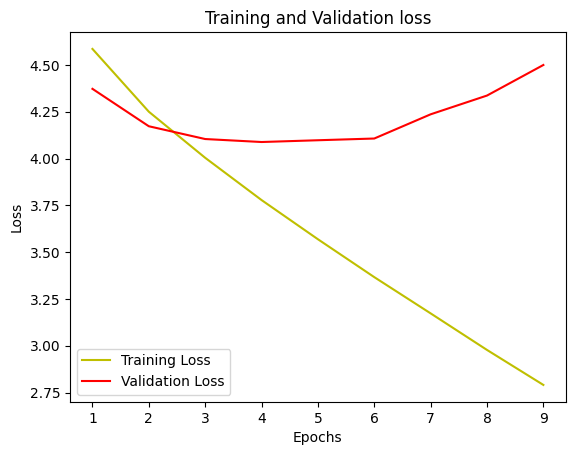

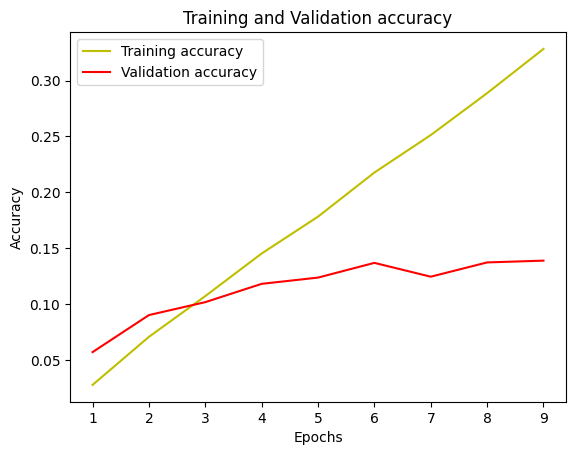

In [15]:
import_results = import_images("yes", 128, (96, 96))
model1 = build_model((3, [16, 32, 48]), (1,228))
hist1 = train_model(model1, 20)
predictions(model1, 16, (96, 96))
history_model(hist1)

### Model 1.1.2 CNN - image_size (96x96) - batch size=64 

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 83s 102ms/step - accuracy: 0.0145 - loss: 4.6973 - val_accuracy: 0.0315 - val_loss: 4.5749
Epoch 2/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 79s 98ms/step - accuracy: 0.0520 - loss: 4.3892 - val_accuracy: 0.0882 - val_loss: 4.2041
Epoch 3/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 79s 98ms/step - accuracy: 0.0943 - loss: 4.0779 - val_accuracy: 0.1034 - val_loss: 4.1756
Epoch 4/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 78s 98ms/step - accuracy: 0.1410 - loss: 3.7803 - val_accuracy: 0.1054 - val_loss: 4.2803
Epoch 5/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 79s 99ms/step - accuracy: 0.1917 - loss: 3.4930 - val_accuracy: 0.1182 - val_loss: 4.4011
Epoch 6/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 77s 97ms/step - accuracy: 0.2468 - loss: 3.1905 - val_accuracy: 0.1006 - val_loss: 4.7229
Epoch 7/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 77s 96ms/step - accuracy: 0.3000 - loss: 2.9295 - val_accuracy: 0.1162 - val_loss: 4.9632
Ep

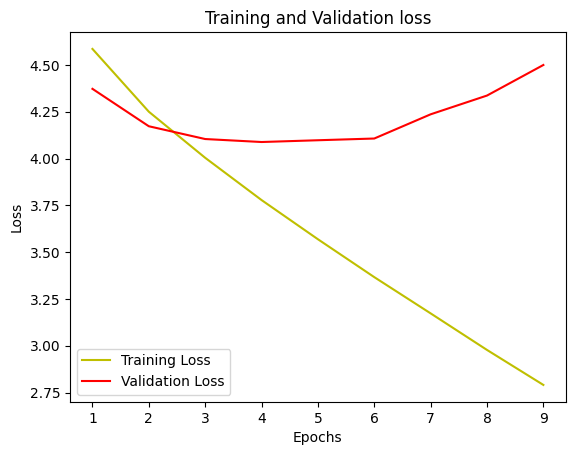

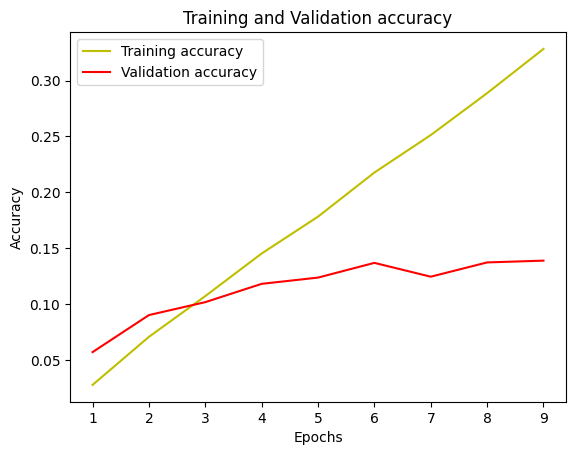

In [16]:
import_results = import_images("yes", 64, (96, 96))
model2 = build_model((3, [16, 32, 48]), (1,228))
hist2 = train_model(model2, 20)
predictions(model2, 16, (96, 96))
history_model(hist1)

## Test dropout

### Model 1.2.1 CNN - image_size (96x96) - batch size=64 + Dropout(0.4)

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 80s 99ms/step - accuracy: 0.0141 - loss: 4.7040 - val_accuracy: 0.0287 - val_loss: 4.6298
Epoch 2/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 78s 98ms/step - accuracy: 0.0404 - loss: 4.5041 - val_accuracy: 0.0579 - val_loss: 4.3764
Epoch 3/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 78s 98ms/step - accuracy: 0.0787 - loss: 4.2245 - val_accuracy: 0.0950 - val_loss: 4.2143
Epoch 4/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 79s 98ms/step - accuracy: 0.1105 - loss: 3.9739 - val_accuracy: 0.0966 - val_loss: 4.1582
Epoch 5/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 78s 98ms/step - accuracy: 0.1408 - loss: 3.7786 - val_accuracy: 0.1146 - val_loss: 4.1232
Epoch 6/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 78s 98ms/step - accuracy: 0.1786 - loss: 3.5544 - val_accuracy: 0.1178 - val_loss: 4.2006
Epoch 7/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 78s 98ms/step - accuracy: 0.2041 - loss: 3.3778 - val_accuracy: 0.1174 - val_loss: 4.2456
Epo

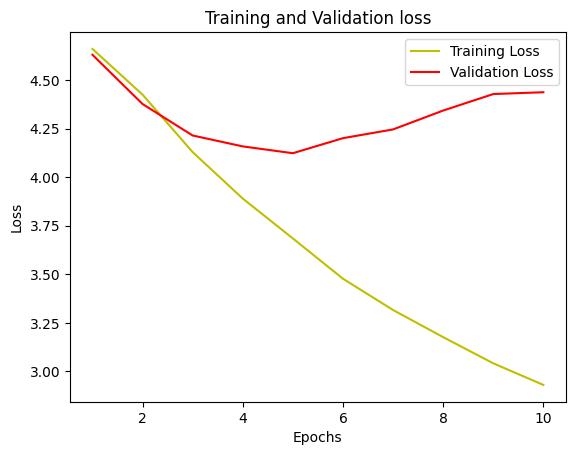

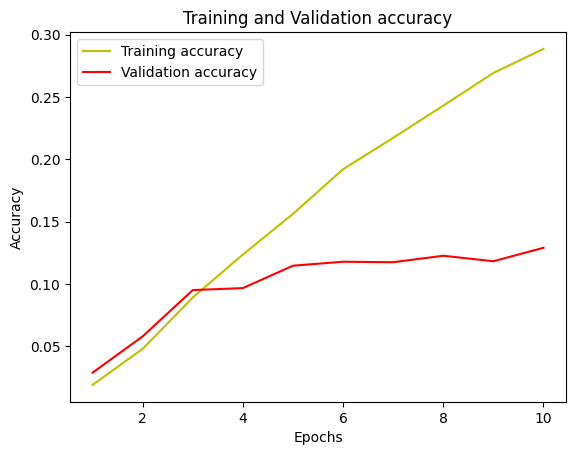

In [18]:
import_results = import_images("yes", 64, (96, 96))
model3 = build_model((3, [16, 32, 48]), (1,228), dropout = 0.4)
hist3 = train_model(model3, 20)
predictions(model3, 16, (96, 96))
history_model(hist3)

### Model 1.2.2 CNN - image_size (96x96) - batch size=64 + Dropout(0.5)

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 80s 99ms/step - accuracy: 0.0156 - loss: 4.6750 - val_accuracy: 0.0435 - val_loss: 4.4987
Epoch 2/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 78s 98ms/step - accuracy: 0.0539 - loss: 4.3738 - val_accuracy: 0.0627 - val_loss: 4.3333
Epoch 3/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 78s 98ms/step - accuracy: 0.0790 - loss: 4.1627 - val_accuracy: 0.1022 - val_loss: 4.0914
Epoch 4/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 79s 98ms/step - accuracy: 0.1119 - loss: 3.9470 - val_accuracy: 0.0990 - val_loss: 4.1190
Epoch 5/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 78s 98ms/step - accuracy: 0.1426 - loss: 3.7600 - val_accuracy: 0.1090 - val_loss: 4.0470
Epoch 6/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 81s 101ms/step - accuracy: 0.1676 - loss: 3.5951 - val_accuracy: 0.1026 - val_loss: 4.2216
Epoch 7/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 79s 99ms/step - accuracy: 0.1935 - loss: 3.4558 - val_accuracy: 0.1050 - val_loss: 4.1764
Ep

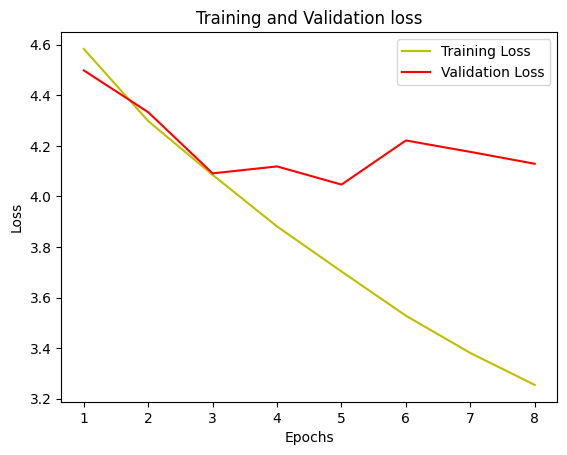

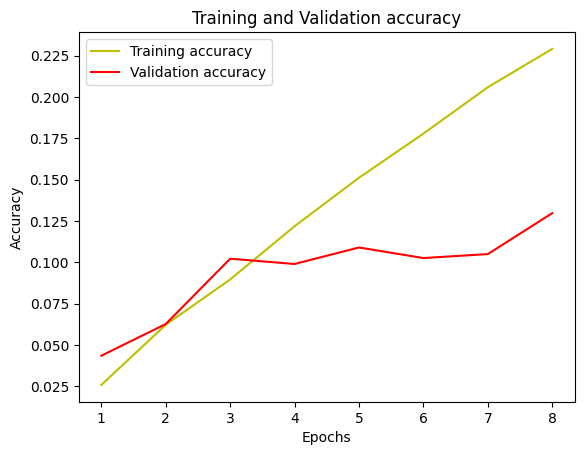

In [8]:
import_results = import_images("yes", 64, (96, 96))
model4 = build_model((3, [16, 32, 48]), (1,228), dropout = 0.5)
hist4 = train_model(model4, 20)
predictions(model4, 16, (96, 96))
history_model(hist4)

### Model 1.2.3 CNN - image_size (96x96) - batch size=64 + Dropout(0.6)

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 80s 99ms/step - accuracy: 0.0152 - loss: 4.6905 - val_accuracy: 0.0463 - val_loss: 4.4712
Epoch 2/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 79s 99ms/step - accuracy: 0.0478 - loss: 4.4100 - val_accuracy: 0.0727 - val_loss: 4.2991
Epoch 3/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 79s 99ms/step - accuracy: 0.0801 - loss: 4.1928 - val_accuracy: 0.0946 - val_loss: 4.1566
Epoch 4/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 80s 100ms/step - accuracy: 0.1069 - loss: 3.9891 - val_accuracy: 0.1046 - val_loss: 4.0767
Epoch 5/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 80s 100ms/step - accuracy: 0.1315 - loss: 3.8368 - val_accuracy: 0.0994 - val_loss: 4.2031
Epoch 6/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 79s 99ms/step - accuracy: 0.1527 - loss: 3.6937 - val_accuracy: 0.1102 - val_loss: 4.1073
Epoch 7/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 80s 100ms/step - accuracy: 0.1741 - loss: 3.5810 - val_accuracy: 0.1269 - val_loss: 4.0410


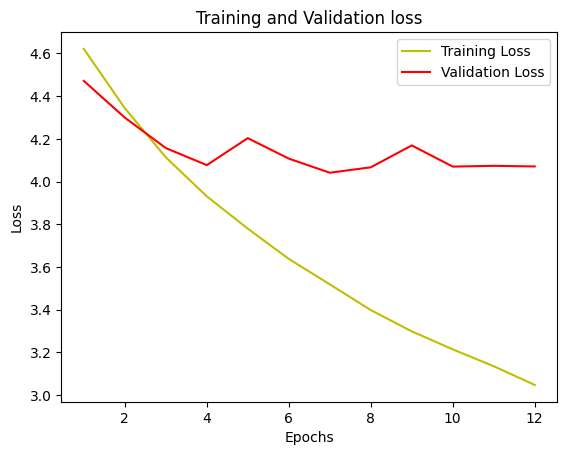

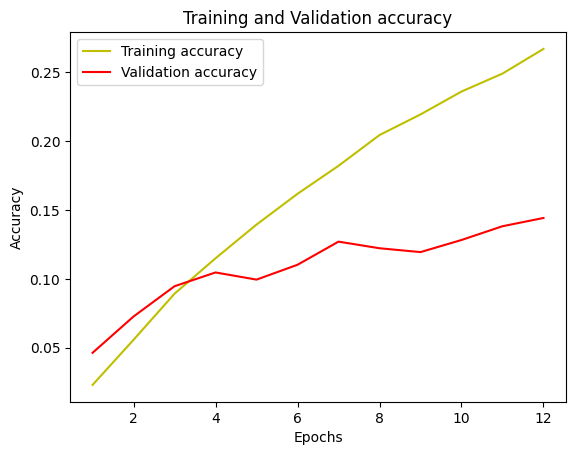

In [21]:
import_results = import_images("yes", 64, (96, 96))
model5 = build_model((3, [16, 32, 48]), (1,228), dropout = 0.6)
hist5 = train_model(model5, 20)
predictions(model5, 16, (96, 96))
history_model(hist5)

## Test learning rate

### Model 1.3.1 CNN - image_size (96x96) - batch size=64 + Dropout(0.6) + Lr(0.0001)

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 86s 106ms/step - accuracy: 0.0110 - loss: 4.7220 - val_accuracy: 0.0303 - val_loss: 4.6035
Epoch 2/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 94s 118ms/step - accuracy: 0.0311 - loss: 4.5730 - val_accuracy: 0.0495 - val_loss: 4.4571
Epoch 3/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 88s 111ms/step - accuracy: 0.0467 - loss: 4.4486 - val_accuracy: 0.0623 - val_loss: 4.3294
Epoch 4/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 95s 119ms/step - accuracy: 0.0609 - loss: 4.3399 - val_accuracy: 0.0778 - val_loss: 4.2777
Epoch 5/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 95s 119ms/step - accuracy: 0.0727 - loss: 4.2611 - val_accuracy: 0.0854 - val_loss: 4.2320
Epoch 6/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 96s 120ms/step - accuracy: 0.0814 - loss: 4.2001 - val_accuracy: 0.0874 - val_loss: 4.2006
Epoch 7/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 89s 111ms/step - accuracy: 0.0897 - loss: 4.1457 - val_accuracy: 0.0930 - val_loss: 4.1

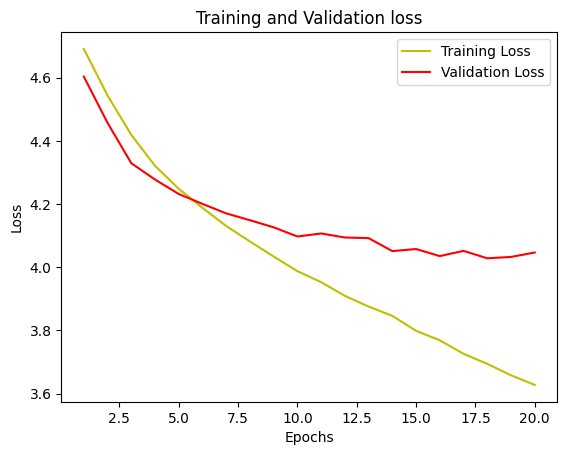

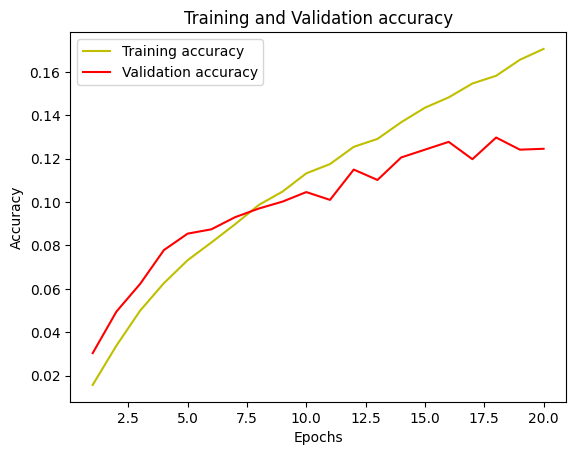

In [9]:
import_results = import_images("yes", 64, (96, 96))
model6 = build_model((3, [16, 32, 48]), (1,228),0.0001, 0.6)
hist6 = train_model(model6, 20)
predictions(model6, 16, (96, 96))
history_model(hist6)

### Model 1.3.2 CNN - image_size (96x96) - batch size=64 + Dropout(0.6) + Lr(0.00001)

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 82s 101ms/step - accuracy: 0.0087 - loss: 4.7415 - val_accuracy: 0.0072 - val_loss: 4.7299
Epoch 2/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 80s 100ms/step - accuracy: 0.0102 - loss: 4.7356 - val_accuracy: 0.0108 - val_loss: 4.7275
Epoch 3/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 79s 99ms/step - accuracy: 0.0107 - loss: 4.7302 - val_accuracy: 0.0180 - val_loss: 4.7175
Epoch 4/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 79s 99ms/step - accuracy: 0.0146 - loss: 4.7181 - val_accuracy: 0.0160 - val_loss: 4.6962
Epoch 5/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 80s 100ms/step - accuracy: 0.0187 - loss: 4.6970 - val_accuracy: 0.0248 - val_loss: 4.6648
Epoch 6/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 81s 101ms/step - accuracy: 0.0234 - loss: 4.6671 - val_accuracy: 0.0275 - val_loss: 4.6389
Epoch 7/100
796/796 ━━━━━━━━━━━━━━━━━━━━ 80s 100ms/step - accuracy: 0.0266 - loss: 4.6393 - val_accuracy: 0.0323 - val_loss

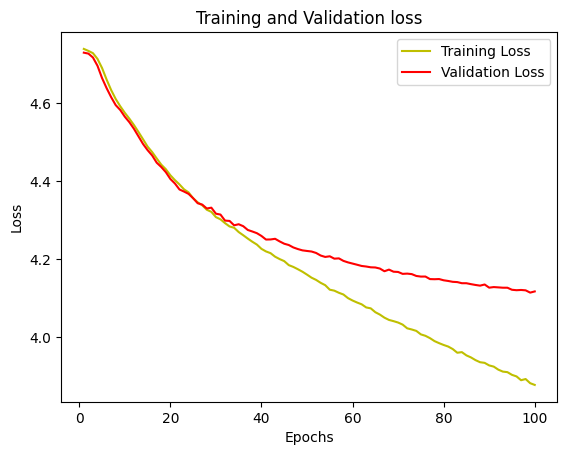

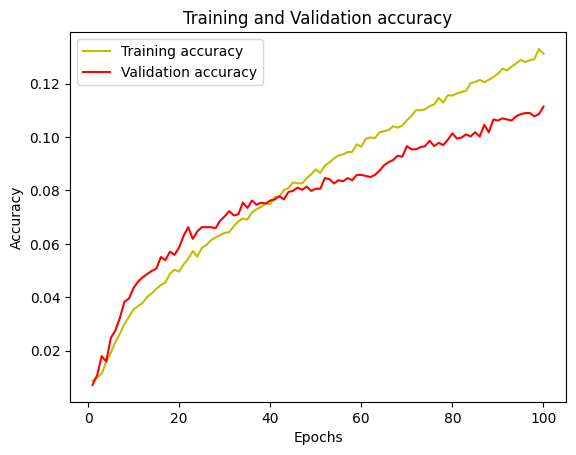

In [23]:
import_results = import_images("yes", 64, (96, 96))
model7 = build_model((3, [16, 32, 48]), (1,228),0.00001, 0.4)
hist7 = train_model(model7, 100)
predictions(model7, 16, (96, 96))
history_model(hist7)

### Model 1.3.3 CNN - image_size (96x96) - batch size=64 + Dropout(0.6) + ReduceLROnPlateau

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/50
796/796 ━━━━━━━━━━━━━━━━━━━━ 84s 104ms/step - accuracy: 0.0134 - loss: 4.7129 - val_accuracy: 0.0267 - val_loss: 4.6122 - learning_rate: 1.0000e-04
Epoch 2/50
796/796 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.0344 - loss: 4.5264 - val_accuracy: 0.0463 - val_loss: 4.4543 - learning_rate: 1.0000e-04
Epoch 3/50
796/796 ━━━━━━━━━━━━━━━━━━━━ 81s 102ms/step - accuracy: 0.0541 - loss: 4.3984 - val_accuracy: 0.0639 - val_loss: 4.3529 - learning_rate: 1.0000e-04
Epoch 4/50
796/796 ━━━━━━━━━━━━━━━━━━━━ 83s 103ms/step - accuracy: 0.0680 - loss: 4.2993 - val_accuracy: 0.0719 - val_loss: 4.3134 - learning_rate: 1.0000e-04
Epoch 5/50
796/796 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.0805 - loss: 4.2163 - val_accuracy: 0.0846 - val_loss: 4.2408 - learning_rate: 1.0000e-04
Epoch 6/50
796/796 ━━━━━━━━━━━━━━━━━━━━ 83s 103ms/step - accuracy: 0.0917 - loss: 4.1359 - val_accuracy: 0.0906 - val_

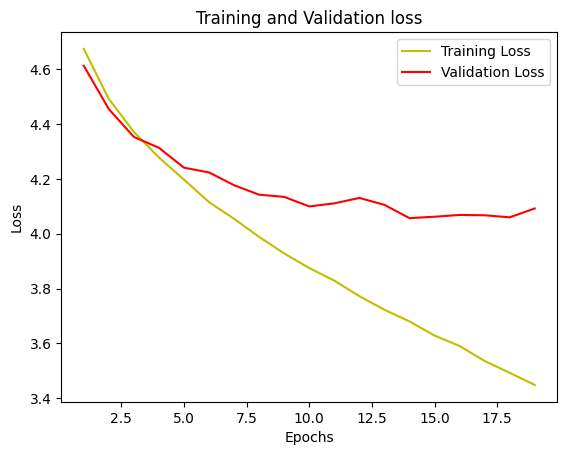

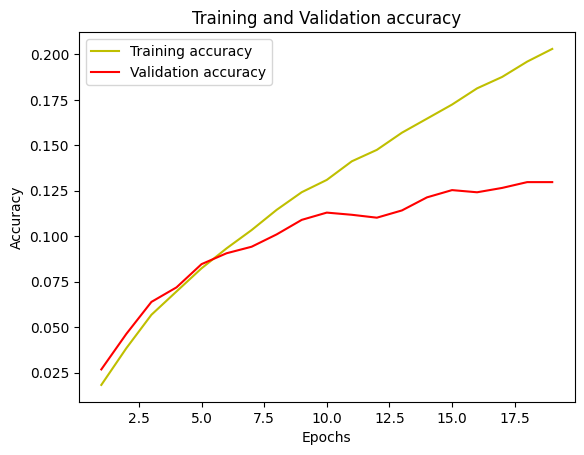

In [24]:
import_results = import_images("yes", 64, (96, 96))
model8 = build_model((3, [16, 32, 48]), (1,228),0.0001, 0.4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
train_generator,val_generator, _ = import_results
hist8 = model8.fit(train_generator, callbacks=[reduce_lr, early_stopping_callback], epochs=50, validation_data=val_generator)
predictions(model8, 16, (96, 96))
history_model(hist8)

## Test batch normalization

### Model 1.4 CNN - image_size (96x96) - batch size=64 + Dropout(0.6) + Lr(0.00001) + BatchNormalization

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/50
796/796 ━━━━━━━━━━━━━━━━━━━━ 235s 292ms/step - accuracy: 0.0099 - loss: 6.2970 - val_accuracy: 0.0068 - val_loss: 6.1871
Epoch 2/50
796/796 ━━━━━━━━━━━━━━━━━━━━ 245s 307ms/step - accuracy: 0.0089 - loss: 4.9091 - val_accuracy: 0.0064 - val_loss: 6.7851
Epoch 3/50
796/796 ━━━━━━━━━━━━━━━━━━━━ 231s 290ms/step - accuracy: 0.0101 - loss: 4.7927 - val_accuracy: 0.0064 - val_loss: 7.2683
Epoch 4/50
796/796 ━━━━━━━━━━━━━━━━━━━━ 223s 279ms/step - accuracy: 0.0084 - loss: 4.7694 - val_accuracy: 0.0060 - val_loss: 7.5488
Epoch 5/50
796/796 ━━━━━━━━━━━━━━━━━━━━ 216s 271ms/step - accuracy: 0.0092 - loss: 4.7543 - val_accuracy: 0.0060 - val_loss: 7.7076
Epoch 6/50
796/796 ━━━━━━━━━━━━━━━━━━━━ 219s 275ms/step - accuracy: 0.0097 - loss: 4.7467 - val_accuracy: 0.0052 - val_loss: 8.0036
Found 2457 files belonging to 114 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1

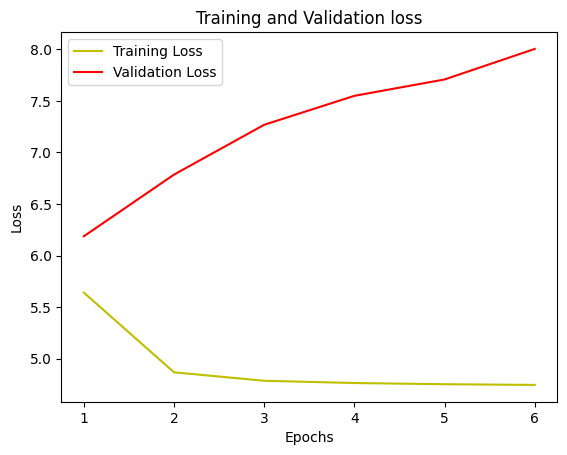

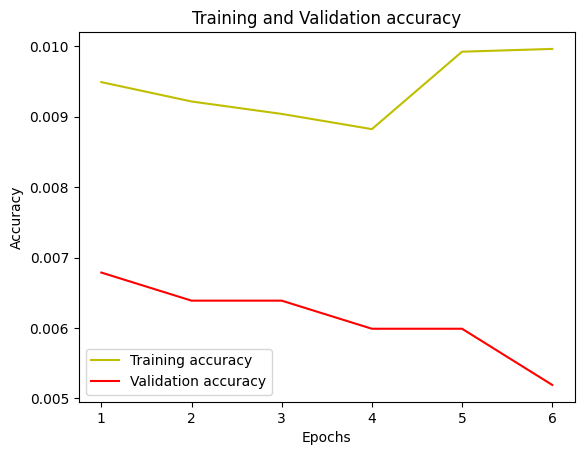

In [25]:
import_results = import_images("yes", 64, (96, 96))
model9 = Sequential([
    Conv2D(16, (3, 3), input_shape = (96, 96, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.6),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.6),
    Conv2D(48, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.6),
    Flatten(),
    Dense(228, activation='relu'),
    Dense(114, activation='softmax')
])
model9.compile(optimizer=Adam(learning_rate=0.00001) , loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
hist9 = train_model(model9, 50)
predictions(model9, 16, (96, 96))
history_model(hist9)

## Test Optimizers

### Model 1.5.1 CNN - image_size (96x96) - batch size=64 + Dropout(0.6) + SGD Optimizer 

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 97s 120ms/step - accuracy: 0.0086 - loss: 4.7517 - val_accuracy: 0.0084 - val_loss: 4.7359
Epoch 2/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 103s 129ms/step - accuracy: 0.0091 - loss: 4.7355 - val_accuracy: 0.0148 - val_loss: 4.7356
Epoch 3/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 98s 123ms/step - accuracy: 0.0087 - loss: 4.7350 - val_accuracy: 0.0184 - val_loss: 4.7354
Epoch 4/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 96s 120ms/step - accuracy: 0.0083 - loss: 4.7349 - val_accuracy: 0.0275 - val_loss: 4.7351
Epoch 5/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 100s 126ms/step - accuracy: 0.0086 - loss: 4.7348 - val_accuracy: 0.0291 - val_loss: 4.7349
Epoch 6/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 101s 127ms/step - accuracy: 0.0105 - loss: 4.7347 - val_accuracy: 0.0307 - val_loss: 4.7348
Epoch 7/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 93s 116ms/step - accuracy: 0.0090 - loss: 4.7342 - val_accuracy: 0.0327 - val_loss: 

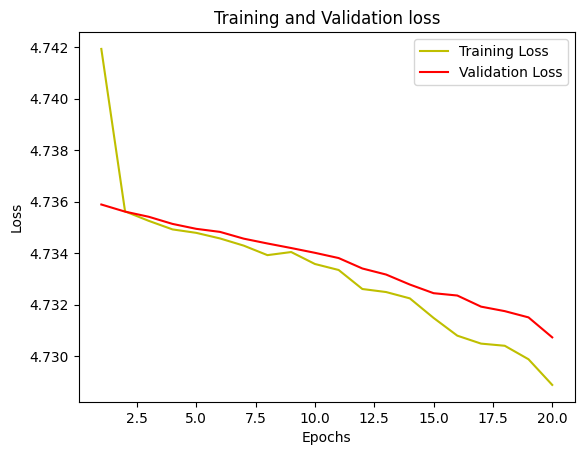

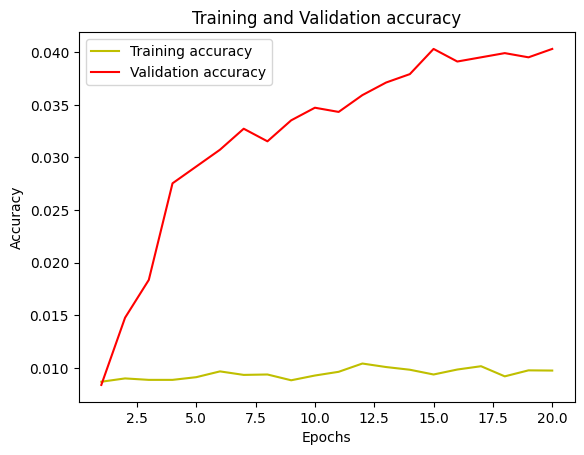

In [32]:
import_results = import_images("yes", 64, (96, 96))
model10 = Sequential([
    Conv2D(16, (3, 3), input_shape = (96, 96, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.6),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.6),
    Conv2D(48, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.6),
    Flatten(),
    Dense(228, activation='relu'),
    Dense(114, activation='softmax')
])
model10.compile(optimizer=SGD(learning_rate=0.001) , loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
hist10 = train_model(model10, 20)
predictions(model10, 16, (96, 96))
history_model(hist10)

### Model 1.5.2 CNN - image_size (96x96) - batch size=64 + Dropout(0.6) + RMSprop Optimizer

Found 50881 files belonging to 114 classes.
Found 2505 files belonging to 114 classes.
Epoch 1/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 93s 115ms/step - accuracy: 0.0087 - loss: 4.8332 - val_accuracy: 0.0160 - val_loss: 4.7358
Epoch 2/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 90s 112ms/step - accuracy: 0.0077 - loss: 4.7373 - val_accuracy: 0.0160 - val_loss: 4.7357
Epoch 3/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 95s 119ms/step - accuracy: 0.0105 - loss: 4.7365 - val_accuracy: 0.0212 - val_loss: 4.7355
Epoch 4/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 85s 106ms/step - accuracy: 0.0080 - loss: 4.7365 - val_accuracy: 0.0259 - val_loss: 4.7353
Epoch 5/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 94s 117ms/step - accuracy: 0.0085 - loss: 4.7360 - val_accuracy: 0.0307 - val_loss: 4.7352
Epoch 6/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 97s 122ms/step - accuracy: 0.0092 - loss: 4.7354 - val_accuracy: 0.0315 - val_loss: 4.7349
Epoch 7/20
796/796 ━━━━━━━━━━━━━━━━━━━━ 103s 129ms/step - accuracy: 0.0098 - loss: 4.7351 - val_accuracy: 0.0379 - val_loss: 4.

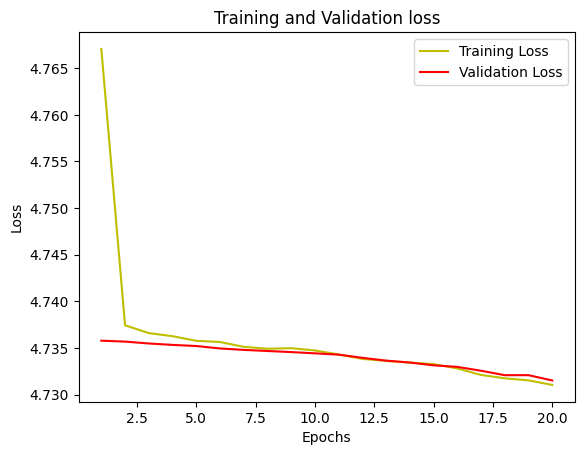

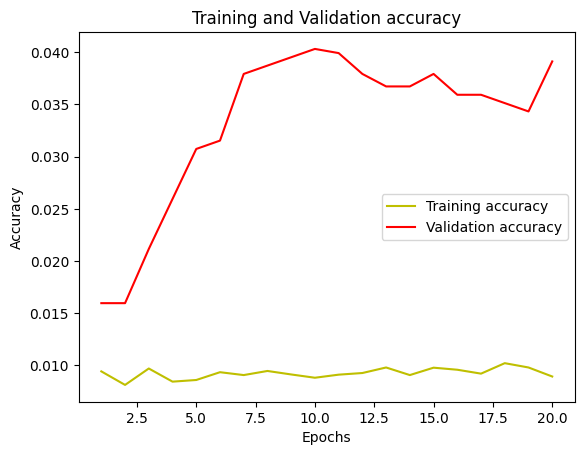

In [33]:
import_results = import_images("yes", 64, (96, 96))
model11 = Sequential([
    Conv2D(16, (3, 3), input_shape = (96, 96, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.6),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.6),
    Conv2D(48, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.6),
    Flatten(),
    Dense(228, activation='relu'),
    Dense(114, activation='softmax')
])
model11.compile(optimizer=SGD(learning_rate=0.001) , loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
hist11 = train_model(model11, 20)
predictions(model11, 16, (96, 96))
history_model(hist11)